#### 本次成绩:95

### 评卷标准:
- 分析，理顺，项目要求并落实在文档中   ？如果能再完善一些会更好，可参考100分同学
- 比较不同结果 ，思考，改进，总结。   √这个完成得好。
- 成绩提交并截图成绩   √
- 最终结论，报告。    √



#### 评卷：David

# House Prices: Advanced Regression Techniques

## 1 项目要求

    让一个购房者描述他们梦想中的房子，他们可能不会从地下室天花板的高度或者靠近东西的铁路开始。但本次比赛的数据集证明。比起卧室或白色栅栏，房屋价格的影响要大得多
    
    本次比赛，以爱荷华州的埃姆斯为背景，采取了79个变量描述了住宅的各个方面，需要你根据已经卖出房屋的价格，预测出还没有卖出的房屋的价格。

    train.csv为训练数据 test.csv为预测数据，请将结果保存为csv文件，并上传

# 2、特征工程

    载入特征处理相关的库

In [55]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["ls", "./"]).decode("utf8")) #check the files available in the directory

## 2.1读取数据、查看数据内容、

In [56]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
train.head(5)

##display the firs

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [57]:
print(test.shape)
test.head(5)

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


    由如上数据可知，数据的第一列为序号样本的标号，对房屋的价格影响，没有实际意义，在训练模型中需要去掉。

    对比训练数据和测试数据，训练数据最后一行为房屋的售价。

    为方便数据处理，先将房屋的id


In [58]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

    离群点处理：
    在数据中会有个别离群点，他们对分类结果噪音太大，我们选择将其删掉。但是如果不是太过分的离群点，就不能删掉，因为如果删掉所有噪声会影响模型的健壮性，对测试数据的泛化能力就会下降。

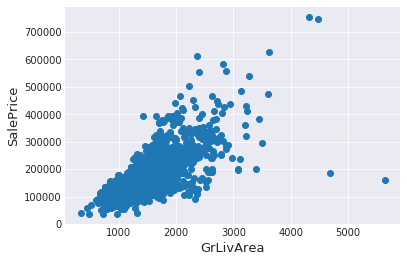

In [59]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

    右下方的两个数据，living area特别大，但是价格又低的离谱，应该是远离市区的无人地带。对最后的分类结果没有影响的离群点（Oultliers），我们可以放心将其删除。

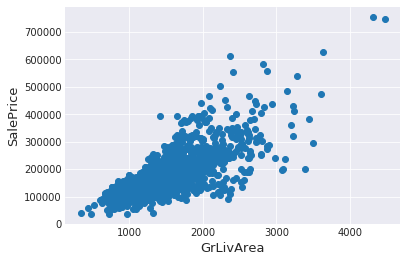

In [60]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## 目标值处理：

线性的模型需要正态分布的目标值才能发挥最大的作用。我们需要检测房价是否偏离正态分布。使用probplot函数


 mu = 180932.92 and sigma = 79467.79



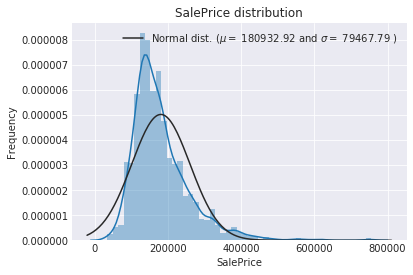

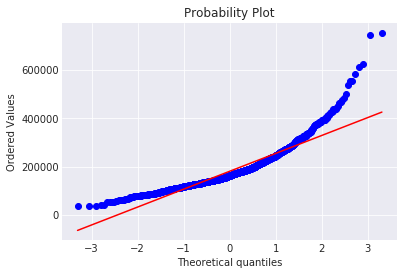

In [61]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

    按照参考文献的说法，此时正态分布明显属于右态分布，整体峰值向左偏离，并且skewness较大，需要对目标值做log转换，以恢复目标值的正态性


 mu = 12.02 and sigma = 0.40



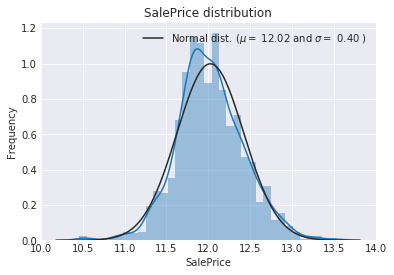

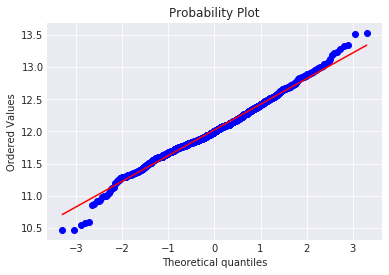

In [62]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## 分析特征数据的情况

分析数据的缺失率

In [63]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [64]:
#all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 
#all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
all_data_na = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,0.997
MiscFeature,0.964
Alley,0.932
Fence,0.804
FireplaceQu,0.487
LotFrontage,0.167
GarageFinish,0.055
GarageQual,0.055
GarageYrBlt,0.055
GarageCond,0.055


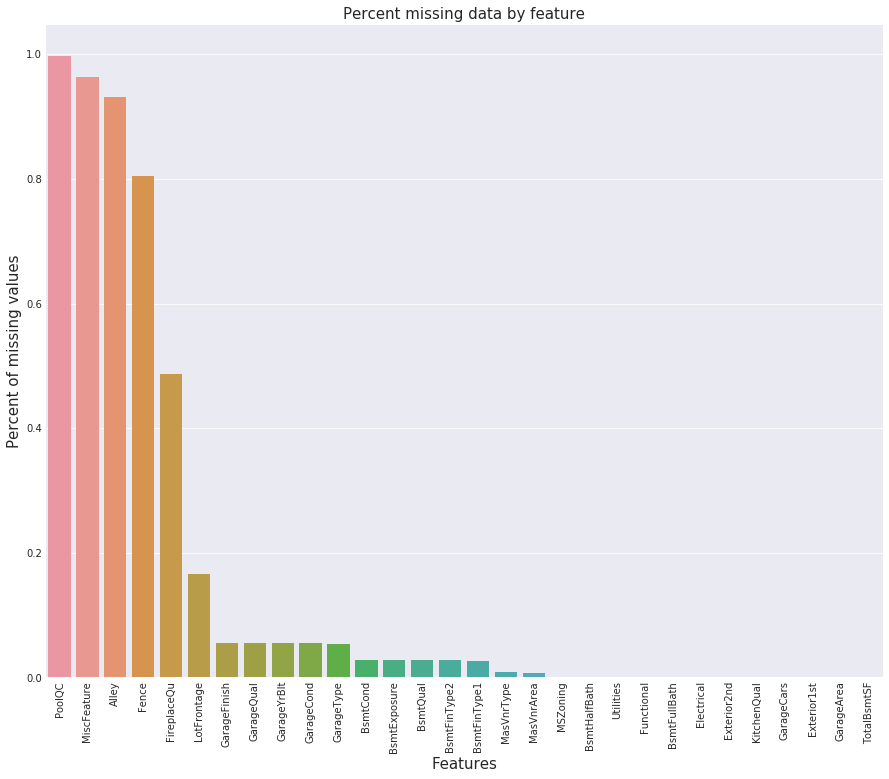

In [65]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

    分析各个特征与房价的相关性，相关性的分析最好使用热力图：

    知识点：
    python pandas 读取excel如果表格大部分列都是100行，但是其中有些列只有90行，此时，使用corr()函数得出所有列之间的关系系数，在其计算corr的时候，遇到空值时是怎么计算的呢？自问自答吧，刚测试了一下，结论是这样的：与只有90行的列对比时，会取其他列对应的行数据来对比，即，在完整的列中剔除部分格子（短缺列中出现nan的格子），然后再计算两列的关系系数。

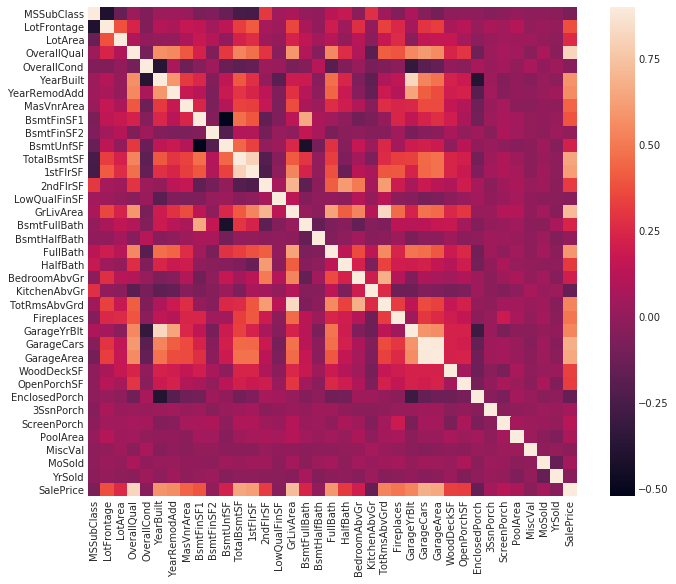

In [66]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

    可以看到对角线有一条白线，这代表相同的特征相关性为最高，但值得注意的是，有两个正方形小块：TotaLBsmtSF和1stFlrSF、GarageAreas和GarageCars处。这代表全部建筑面积TotaLBsmtSF与一层建筑面积1stFlrSF成强正相关，车库区域GarageAreas和车库车辆GarageCars成强正相关，那么在填补缺失值的时候就有了依据，我们可以直接删掉一个多余的特征或者使用一个填补另一个。

    我们按顺序依次通过缺少值的特性来估算它们

    PoolQC MiscFeature Alley Fence FireplaceQu 数据描述说NA的意思是“没有”，因此全部用None填充

In [67]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

    由于每条街道的面积与房屋的面积很可能与附近的其他房屋有相似的区域，所以我们可以通过小区的中位数来填补缺失的价值
    
    按邻区分组，并通过所有社区的中位数来填补缺失的价值

In [68]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

GarageType, GarageFinish, GarageQual and GarageCond : 用None填充数值

In [69]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

    GarageYrBlt, GarageArea and GarageCars :用 0 代替缺失值 (大部分情况下，因为没有车库就等于没有车。)

In [70]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

    BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath：没有地下室，很可能是0

In [71]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

    BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 ：对于所有这些与分类相关的特性，NaN的意思是没有地下室

In [72]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

    MasVnrArea和MasVnrType：最可能的意思是这些房子没有砌体的单板。我们可以为这个区域填满0，类型为NAN。

In [73]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

    MSZoning (The general zoning classification) ： “RL”是目前为止最常见的价值。所以我们可以用"RL"来填充缺失的值

In [74]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

    Utilities:对于这个分类特征，所有的记录都是“AllPub”，除了一个 "NoSeWa"和2 NA。由于NoSeWa尽在训练集中，因此这个值对于预测模型没有用处，可以直接删除

In [75]:
all_data = all_data.drop(['Utilities'], axis=1)

    Functional : 数据描述说,NA意味着 typical

In [76]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

    Electrical : 有一个 NA . 由于这个特征最多的值是 'SBrkr', 我们可以用这个值填充缺失值

In [77]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

    KitchenQual: 只有一个 NA , 同样, 我们可以用 'TA'（最常用） 填充缺失值。

In [78]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

     Exterior1st and Exterior2nd:同如上原则，最常用值填充。

In [79]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [80]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

    MSSubClass : Na意味着没有建筑，因此我们可以用 None填充缺失值。

In [81]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

    查看是否仍然存在缺失值。如下输出可以看出，没有缺失值了。

In [82]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


    有许多特征实际上是类别型的特征，但给出来的是数字。比如MSSubClass，是评价房子种类的一个特征，给出的是10-100的数字，但实际上是类别，所以我们需要将其转化为字符串类别

In [83]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

    接下来 LabelEncoder，对文本类别的特征进行编号

In [84]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


    接下来添加一个重要的特征，因为我们实际在购买房子的时候会考虑总面积的大小，但是此数据集中并没有包含此数据。总面积等于地下室面积+1层面积+2层面积

In [85]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

    我们对房价进行分析，不符合正态分布我们将其log转换，使其符合正态分布。那么偏离正态分布太多的特征我们也对它进行转化：

In [86]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [87]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


    将类别特征进行哑变量转化：

In [88]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


    至此，我们的特征工程已经处理完毕。

In [89]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# 建模

In [90]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

    我们使用Sklearn的cross_val_score函数。然而这个函数没有shuffle方法，我们添加了一行代码，为了在交叉验证之前shuffle数据集。

In [91]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 基本模型

    LASSO Regression:模型原理与简介见http://www.sohu.com/a/115799487_500658

     LASSO回归与Ridge回归同属于一个被称为Elastic Net的广义线性模型家族。 这一家族的模型除了相同作用的参数λ之外，还有另一个参数α来控制应对高相关性(highly correlated)数据时模型的性状。 LASSO回归α=1，Ridge回归α=0，一般Elastic Net模型0<α<1

    这个模型可能对异常值非常敏感。所以我们需要让它更坚固。为此，我们在管道上使用sklearn的RobustScaler（）方法
    
    含异常值数据缩放robust_scale，它们使用更加鲁棒的中心和范围估计来缩放你的数据

In [92]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

    Elastic Net Regression

    继续使用RobustScaler，再次对异常值进行了健壮性

In [93]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

    Kernel Ridge Regression：核岭回归

In [94]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

    Gradient Boosting Regression：With huber loss that makes it robust to outliers

In [95]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

    XGBoost

In [96]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

## 基本模型得分

    接下来，让我们看一下这些模型在验证集上的效果

In [97]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [98]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [99]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [100]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# 模型融合

        最简单的叠加方法：平均基础模型

    我们从这个简单的平均模型的方法开始。我们构建了一个新的类来扩展scikit-learn与我们的模型，并进行封装，方便代码重用（继承）

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

    我们可以看到，最简单的模型叠加方法，也能够提高分数，为此，我们探讨一个更加复杂的模型融合方法

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## 稍微复杂的模型融合，增加一个元模型

    在这种方法中，我们在平均基础模型上添加了一个元模型，并使用这些基础模型的超出折叠的预测来训练我们的元模型。

    算法：

1、将整个训练集分解成两个不相交的集合（这里是train和.holdout）。 


2、在第一部分（train）上训练几个基本模型。 


3、在第二个部分（holdout）上测试这些基本模型。


4、使用(3)中的预测（称为 out-of-fold 预测）作为输入，并将正确的标签（目标变量）作为输出来训练更高层次的学习模型称为元模型。



前三个步骤是迭代完成的。例如，如果我们采取5倍的fold，我们首先将训练数据分成5次。然后我们会做5次迭代。在每次迭代中，我们训练每个基础模型4倍，并预测剩余的fold（holdout fold）。

<img src="modelpicture.png"width="100%"> 

<img src="testprocess.png"width="100%"> 

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

    为了使这两种方法具有可比性（通过使用相同数量的模型），我们将Enet KRR and Gboost作为基模型，然后我们将lasso添加为元模型

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

    测试Meta-model Stacking结果：

In [ ]:
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

## 融合 StackedRegressor, XGBoost

    定义一个新的评估函数

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

    XGBoost:

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.30))

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.30

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission6.csv',index=False)

    提交记录

<img src="kaggel-image.png" width="100%">  

    成绩分析：
    
        0.13579：进行数据处理之后，仅使用了单一的模型，随机森林。
        0.12143：使用了多个模型，并对每一个模型使用了相同的权重，简单的均值相加。
        9.45381：计算结果后，忘记了取指数。
        0.11571：使用了多种模型，并使用了不同的权重。
        

    提交排名

<img src="rank.png" width="100%"> 

# 项目总结

通过完成本项目，掌握了如下技能：

1.进一步巩固了pandas数据处理函数的使用能力。

2.掌握了特征工程中数据处理的原则，包括查找离群点、舍弃离群点；计算各个特征之间的相关性，并用热力图表示；分析数据的缺失值和处理缺失值；将类型数据转换为字符型，将非数值型数据进行one-hot编码等。

3.进一步巩固了sklearn中随机森林、岭回归等算法的使用，见证了模型融合相对于单模型所展现的强大魅力。

4.掌握了kaggle比赛的基本流程，步入了一个有趣的新领域。

项目参考：https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


        https://blog.csdn.net/Irving_zhang/article/details/78561105
        

        https://blog.csdn.net/qq_27668313/article/details/79034484
        
        https://blog.csdn.net/masbbx123/article/details/79315107
        
        https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
        
        https://blog.csdn.net/aliceyangxi1987/article/details/71079448
        
        http://www.sohu.com/a/115799487_500658